In [30]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

import os, re
import glob

import sklearn
import statsmodels
from sklearn.model_selection import train_test_split 

import tensorflow as tf
from tensorflow import keras

from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Project_Writing_Lyrics

## (1) 데이터 불러오기

In [32]:
txt_list = glob.glob('/content/drive/MyDrive/lyrics/*')

In [33]:
raw_corpus = [] 

for txt_file in txt_list:
    with open(txt_file, 'r') as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["Let's stay together I, I'm I'm so in love with you", 'Whatever you want to do', 'Is all right with me']


## (2) 데이터 전처리

### 1) 특수문자 제거
정규표현식을 이용한 corpus 생성

In [34]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0 : continue
    if sentence[-1] == ":" : continue 

    def preprocess_sentence(sentence):
        sentence = sentence.lower().strip()                  # 1. 소문자로 바꾸고, 양쪽 공백을 지움
        sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)   # 2. 특수문자 양쪽에 공백을 넣음
        sentence = re.sub(r'[" "]+', " ", sentence)          # 3. 여러개의 공백은 하나의 공백으로 바꿈
        sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿈
        sentence = sentence.strip()                          # 5. 다시 양쪽 공백을 지움
        sentence = '<start> ' + sentence + ' <end>'          # 6. 문장 시작에는 <start>, 끝에는 <end>를 추가
        return sentence
    
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
    
corpus[:5]

['<start> let s stay together i , i m i m so in love with you <end>',
 '<start> whatever you want to do <end>',
 '<start> is all right with me <end>',
 '<start> cause you make me feel so brand new <end>',
 '<start> and i want to spend my life with you let me say that since , baby , since we ve been together <end>']

In [35]:
len(corpus)

175749

### 2) Tokenization & Padding

tf.keras.preprocessing.text.Tokenizer를 이용해 corpus를 텐서로 변환

In [36]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=12000, filters=' ', oov_token="<unk>")
    tokenizer.fit_on_texts(corpus)                   # 문자 데이터 입력 받아 리스트 형태로 변환하는 메서드, corpus를 이용해 tokenizer 내부 단어장 완성
    tensor = tokenizer.texts_to_sequences(corpus)    # 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=20, padding='post')   
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2  63  16 ...   0   0   0]
 [  2 598   7 ...   0   0   0]
 [  2  26  24 ...   0   0   0]
 ...
 [  2 130   5 ...   0   0   0]
 [287  79 162 ... 874 647   3]
 [  2   7  34 ...   0   0   0]] <keras.preprocessing.text.Tokenizer object at 0x7f9241daf0a0>


In [37]:
print(tensor[:3, :20])

[[  2  63  16 222 283   5   4   5  22   5  22  30  14  33  31   7   3   0
    0   0]
 [  2 598   7  62  10  47   3   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  2  26  24  84  31  12   3   0   0   0   0   0   0   0   0   0   0   0
    0   0]]


In [38]:
# tokenizer.index_word: 현재 계산된 단어의 인덱스와 인덱스에 해당하는 단어를 dictionary 형태로 반환
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 20: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to
11 : it
12 : me
13 : my
14 : in
15 : t
16 : s
17 : that
18 : on
19 : of
20 : .


In [39]:
source_input = tensor[:, :-1]     # tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성. 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높음    
target_input = tensor[:, 1:]      # tensor에서 <start>를 잘라내서 타겟 문장을 생성

print(source_input[0])
print(target_input[0])

[  2  63  16 222 283   5   4   5  22   5  22  30  14  33  31   7   3   0
   0]
[ 63  16 222 283   5   4   5  22   5  22  30  14  33  31   7   3   0   0
   0]


In [40]:
# corpus 내의 첫 번째 문장에 대해 생성된 소스와 타겟 문장을 확인해 보면
# 예상대로 소스는 2(start)에서 시작해서 3(end)으로 끝난 후 0(pad)로 채워져 있고, 
# 타겟은 2로 시작하지 않고 소스를 왼쪽으로 한 칸 시프트 한 형태를 가지고 있다.

## (3) Train_data, Validation_data 생성

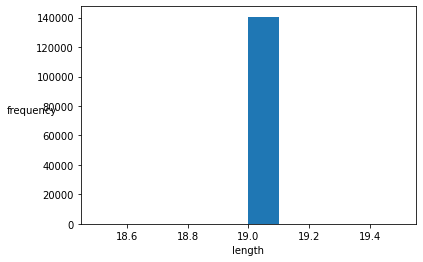

In [41]:
x_train, x_val, y_train, y_val = train_test_split(source_input, target_input, test_size=0.2, random_state=42)

lengths = np.array([len(i) for i in x_train])

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency', rotation=0)
plt.show()

## (4) 인공지능(model) 만들기

### 1) Model 설계하기

In [42]:
class TextGenerator(tf.keras.Model):
    
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

embedding_size = 256   # 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기
hidden_size = 1024     # 모델에 얼마나 많은 일꾼을 둘 것인가?
model = TextGenerator(tokenizer.num_words+1, embedding_size, hidden_size)

### 2) Model 학습 & 평가

In [43]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')  
model.compile(optimizer=optimizer, loss=loss)

history = model.fit(x_train, y_train, epochs=10, verbose=1, batch_size=256, validation_data=(x_val, y_val))
history

Epoch 1/10
550/550 [==============================] - 134s 235ms/step - loss: 2.9461 - val_loss: 2.6067
Epoch 2/10
550/550 [==============================] - 128s 234ms/step - loss: 2.5121 - val_loss: 2.4626
Epoch 3/10
550/550 [==============================] - 129s 234ms/step - loss: 2.3810 - val_loss: 2.3691
Epoch 4/10
550/550 [==============================] - 138s 250ms/step - loss: 2.2802 - val_loss: 2.3006
Epoch 5/10
550/550 [==============================] - 138s 251ms/step - loss: 2.1945 - val_loss: 2.2443
Epoch 6/10
550/550 [==============================] - 129s 235ms/step - loss: 2.1177 - val_loss: 2.1963
Epoch 7/10
550/550 [==============================] - 138s 251ms/step - loss: 2.0462 - val_loss: 2.1586
Epoch 8/10
550/550 [==============================] - 138s 251ms/step - loss: 1.9789 - val_loss: 2.1242
Epoch 9/10
550/550 [==============================] - 129s 235ms/step - loss: 1.9145 - val_loss: 2.0954
Epoch 10/10
550/550 [==============================] - 129s 234m

In [44]:
model.summary()

Model: "text_generator_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  3072256   
                                                                 
 lstm_4 (LSTM)               multiple                  5246976   
                                                                 
 lstm_5 (LSTM)               multiple                  8392704   
                                                                 
 dense_2 (Dense)             multiple                  12301025  
                                                                 
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


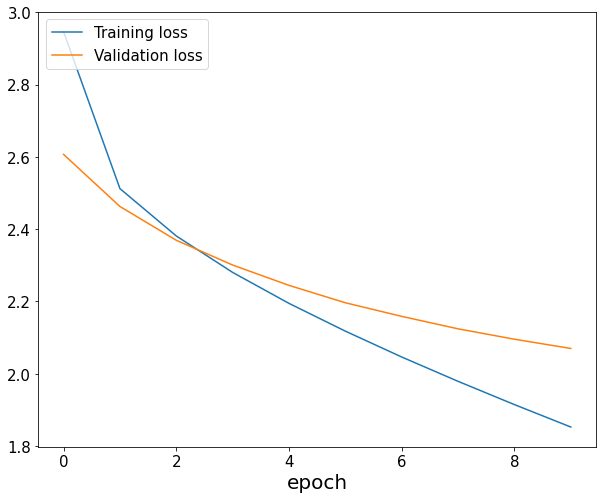

In [45]:
plt.figure(figsize = (10, 8))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Training loss', 'Validation loss'], loc='upper left', fontsize=15)

plt.show()

### 3) Drop-out (0.3)

In [63]:
model_new = keras.Sequential()
model_new.add(keras.layers.Embedding(12001, 256))
model_new.add(keras.layers.LSTM(1024, return_sequences=True, dropout=0.3))
model_new.add(keras.layers.LSTM(1024, return_sequences=True, dropout=0.3))
model_new.add(keras.layers.Dense(12001, activation='sigmoid' ))

In [64]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')  
model_new.compile(optimizer=optimizer, loss=loss)

history = model_new.fit(x_train, y_train, epochs=10, verbose=1, batch_size=256, validation_data=(x_val, y_val))
history

Epoch 1/10
550/550 [==============================] - 143s 253ms/step - loss: 2.8775 - val_loss: 2.5802
Epoch 2/10
550/550 [==============================] - 139s 252ms/step - loss: 2.4971 - val_loss: 2.4452
Epoch 3/10
550/550 [==============================] - 130s 236ms/step - loss: 2.3710 - val_loss: 2.3518
Epoch 4/10
550/550 [==============================] - 139s 252ms/step - loss: 2.2733 - val_loss: 2.2837
Epoch 5/10
550/550 [==============================] - 139s 253ms/step - loss: 2.1915 - val_loss: 2.2305
Epoch 6/10
550/550 [==============================] - 139s 253ms/step - loss: 2.1182 - val_loss: 2.1862
Epoch 7/10
550/550 [==============================] - 130s 236ms/step - loss: 2.0508 - val_loss: 2.1492
Epoch 8/10
550/550 [==============================] - 130s 236ms/step - loss: 1.9878 - val_loss: 2.1153
Epoch 9/10
550/550 [==============================] - 130s 236ms/step - loss: 1.9290 - val_loss: 2.0878
Epoch 10/10
550/550 [==============================] - 139s 253m

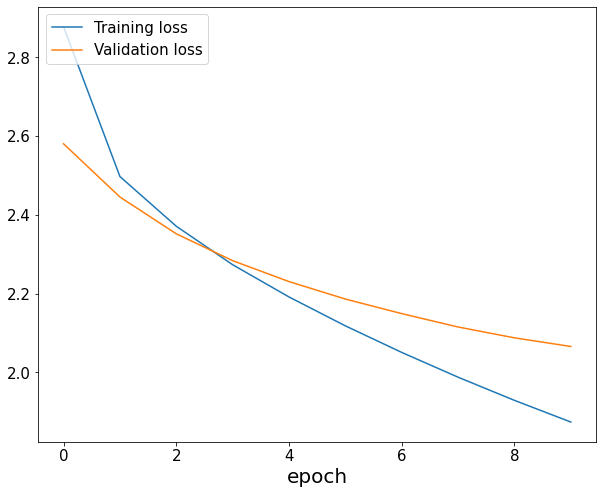

In [65]:
plt.figure(figsize = (10, 8))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Training loss', 'Validation loss'], loc='upper left', fontsize=15)

plt.show()

### 4) "I am a Lyricist."

In [74]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    while True:
        predict = model(test_tensor)
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    for word_index in test_tensor[0].numpy(): 
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [90]:
generate_text(model, tokenizer, init_sentence="<start> i am")

'<start> i am the one <end> '

# 2. Conclusion

(1) 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 토큰의 개수가 20개를 넘어가는 문장을 학습 데이터에서 제외했다.

    → Padding 단계에서 pad_sequences 함수에 maxlen=20을 설정 : 샘플의 길이를 20에 맞추고 부족할 때는 패딩을 추가

    → tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=20, padding='post') 

(2) embedding_size = 256, hidden_size = 1024로 설정

    → Validation_loss 값 2.0698

(3) Dropout(0.3)

    → (4)-2) 그래프를 보면 LSTM이 과대적합을 억제하면서 훈련을 잘 수행하였다. 
      하지만 과대적합을 더 강하게 제어해 보기 위해 드롭아웃을 순환층에 적용해 보았고, 그 결과 훈련 손실이 약간 향상 되었다. 
      훈련 손실과 검증 손실 그래프를 그려보면 LSTM 층에 적용한 드롭아웃이 효과가 있었으며 
      훈련 손실과 검증 손실 간의 차이가 좁혀진 것을 확인할 수 있다. (0.2173 → 0.1918)


# 3. References

[1] https://lms.aiffel.io/course/382/node/507

[2] 혼자 공부하는 머신러닝 + 딥러닝